# Set up workspace

## Import packages etc

In [128]:
import pandas as pd
import numpy as np
import re
import datetime
from matplotlib import pyplot as plt
from azureml.core import Workspace, Dataset, workspace

subscription_id = 'f2b69fae-1dd7-434d-88d6-fb9cbdd0bd17'
resource_group = 'hackathon'
workspace_name = 'Iteration1_ML'

workspace = Workspace(subscription_id, resource_group, workspace_name)

# Set up experiment

In [129]:
import logging

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
import os

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

import azureml.core
from azureml.core import Experiment, Workspace, Dataset
from azureml.train.automl import AutoMLConfig
from datetime import datetime

In [130]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'COVID_model_JP'

# # project folder
# project_folder = './sample_projects/automl-forecasting-energy-demand'

experiment = Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,f2b69fae-1dd7-434d-88d6-fb9cbdd0bd17
Workspace,iteration1_ml
Resource Group,hackathon
Location,eastus2
Run History Name,COVID_model_JP


# Create AmlCompute

In [131]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your cluster.
amlcompute_cluster_name = "flights-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS12_V2',
                                                           max_nodes=6)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


### Set up designated variables

In [132]:
target_column_name = 'counts_x'
time_column_name = 'Date'

## Read in data as dataset tabular object

In [133]:
dataset = Dataset.get_by_name(workspace, name='ATL_training_autoML').with_timestamp_columns(fine_grain_timestamp=time_column_name) 
#preview first 5 rows
dataset.take(5).to_pandas_dataframe().reset_index(drop=True)

,Column2,Departure_Airport,Date,Departure_state_x,counts_x,DOW_x,DOW_num_x,day_x,month_x,month_num_x,...,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
0,19556,ATL,2019-01-01,GA,952,Tuesday,1,1,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,19562,ATL,2019-01-02,GA,1241,Wednesday,2,2,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,19568,ATL,2019-01-03,GA,1162,Thursday,3,3,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,19574,ATL,2019-01-04,GA,1164,Friday,4,4,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,19580,ATL,2019-01-05,GA,865,Saturday,5,5,January,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#Data Exploration

In [134]:
explore =dataset.time_between(datetime(2020, 3, 1, 0), datetime(2020, 9, 30, 0))
explore=explore.to_pandas_dataframe().reset_index(drop=True)

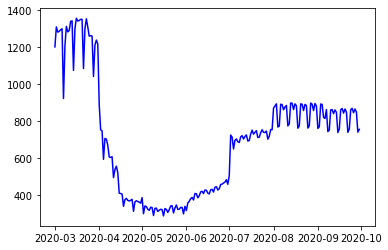

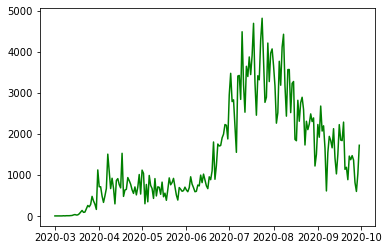

In [135]:
#do some plotting
%matplotlib inline
flight_cnts = plt.plot(explore['Date'], explore['counts_x'], color='b')
plt.show()

covid_cnts = plt.plot(explore['Date'], explore['positiveIncrease'], color='g')
plt.show()

#Correlation

In [136]:
corr_matrix=explore.corr(method='pearson', min_periods=1)
with pd.option_context("display.min_rows", 50, "display.max_rows", 100, "display.max_columns", 5):
    display(corr_matrix)

,counts_x,DOW_num_x,...,positiveScore,score
counts_x,1.00,-0.02,...,nan,nan
DOW_num_x,-0.02,1.00,...,nan,nan
day_x,-0.03,-0.00,...,nan,nan
month_num_x,-0.06,-0.00,...,nan,nan
week_of_year_x,-0.06,-0.04,...,nan,nan
index,-0.06,-0.00,...,nan,nan
mint,-0.03,0.00,...,nan,nan
maxt,-0.14,0.09,...,nan,nan
temp,-0.11,0.05,...,nan,nan
dew,0.02,-0.04,...,nan,nan


### Split the data into train and test sets

In [138]:
# split into train based on time
train0 =dataset.time_between(datetime(2020, 7, 1, 0), datetime(2020, 11, 30, 0))
train0.to_pandas_dataframe().reset_index(drop=True).sort_values(time_column_name).tail(5)

,Column2,Departure_Airport,Date,Departure_state_x,counts_x,DOW_x,DOW_num_x,day_x,month_x,month_num_x,...,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
148,21536,ATL,2020-11-26,GA,733,Thursday,3,26,November,11,...,461517.00,30762.00,461517.00,39.00,174.00,0.00,0.00,0.00,0.00,0.00
149,21542,ATL,2020-11-27,GA,905,Friday,4,27,November,11,...,464526.00,31722.00,464526.00,44.00,18.00,0.00,0.00,0.00,0.00,0.00
150,21548,ATL,2020-11-28,GA,1088,Saturday,5,28,November,11,...,467564.00,30611.00,467564.00,44.00,119.00,0.00,0.00,0.00,0.00,0.00
151,21554,ATL,2020-11-29,GA,1111,Sunday,6,29,November,11,...,469516.00,13903.00,469516.00,18.00,58.00,0.00,0.00,0.00,0.00,0.00
152,21560,ATL,2020-11-30,GA,1121,Monday,0,30,November,11,...,471563.00,11521.00,471563.00,10.00,42.00,0.00,0.00,0.00,0.00,0.00


In [139]:
# split into test based on time
test0 = dataset.time_between(datetime(2020, 12, 1, 0), datetime(2020, 12, 31, 0))
test0.to_pandas_dataframe().reset_index(drop=True).head(5)

,Column2,Departure_Airport,Date,Departure_state_x,counts_x,DOW_x,DOW_num_x,day_x,month_x,month_num_x,...,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
0,21566,ATL,2020-12-01,GA,1060,Tuesday,1,1,December,12,...,476405.00,24519.00,476405.00,63.00,239.00,0.00,0.00,0.00,0.00,0.00
1,21572,ATL,2020-12-02,GA,865,Wednesday,2,2,December,12,...,482139.00,23997.00,482139.00,52.00,263.00,0.00,0.00,0.00,0.00,0.00
2,21578,ATL,2020-12-03,GA,967,Thursday,3,3,December,12,...,487978.00,33701.00,487978.00,81.00,245.00,0.00,0.00,0.00,0.00,0.00
3,21584,ATL,2020-12-04,GA,968,Friday,4,4,December,12,...,494354.00,38355.00,494354.00,77.00,212.00,0.00,0.00,0.00,0.00,0.00
4,21590,ATL,2020-12-05,GA,847,Saturday,5,5,December,12,...,499371.00,31180.00,499371.00,68.00,218.00,0.00,0.00,0.00,0.00,0.00


### There are too many input columns.  Do first round of feature selection

In [140]:
varsToKeep=['Departure_Airport',
'Date',
'Departure_state_x',
'counts_x',
'DOW_x',
'day_x',
'month_x',
'mint',
'maxt',
'temp',
'dew',
'humidity',
'wspd',
'precip',
'precipcover',
'snowdepth',
'visibility',
'cloudcover',
'sealevelpressure',
'weathertype',
'conditions',
'positiveIncrease',
'deathIncrease',
'hospitalizedIncrease']

# =============================================================================
# removed these for being cumulative
#'positive',
#'probableCases',
#'hospitalizedCurrently',
#'inIcuCurrently',
#'onVentilatorCurrently',
#'death',

#removed these for being missing
#'wgust',
#'windchill',
#'heatindex',
# =============================================================================

In [141]:
train=train0.keep_columns(varsToKeep)
test=test0.keep_columns(varsToKeep)

In [142]:
#print for viewing
train.to_pandas_dataframe().reset_index(drop=True).head(5)

,Departure_Airport,Date,Departure_state_x,counts_x,DOW_x,day_x,month_x,mint,maxt,temp,...,precipcover,snowdepth,visibility,cloudcover,sealevelpressure,weathertype,conditions,positiveIncrease,deathIncrease,hospitalizedIncrease
0,ATL,2020-07-01,GA,505,Wednesday,1,July,69.20,82.10,75.00,...,8.33,0.00,9.90,62.10,1013.10,Light Rain,"Rain, Partially cloudy",2946.00,22.00,224.00
1,ATL,2020-07-02,GA,725,Thursday,2,July,71.00,89.00,79.00,...,16.67,0.00,9.70,52.20,1012.60,"Lightning Without Thunder, Thunderstorm, Rain, Heavy Rain","Rain, Partially cloudy",3472.00,22.00,225.00
2,ATL,2020-07-03,GA,714,Friday,3,July,74.90,91.10,82.80,...,0.00,0.00,9.80,49.60,1013.40,Mist,Partially cloudy,2784.00,7.00,153.00
3,ATL,2020-07-04,GA,650,Saturday,4,July,74.90,89.90,81.20,...,12.50,0.00,9.10,49.20,1013.00,"Lightning Without Thunder, Mist, Thunderstorm, Light Rain, Smoke Or Haze","Rain, Partially cloudy",2826.00,1.00,90.00
4,ATL,2020-07-05,GA,697,Sunday,5,July,74.00,91.10,82.70,...,0.00,0.00,7.20,53.70,1013.40,"Mist, Fog, Smoke Or Haze",Partially cloudy,2197.00,3.00,32.00


In [143]:
#print for viewing
test.to_pandas_dataframe().reset_index(drop=True).head(5)

,Departure_Airport,Date,Departure_state_x,counts_x,DOW_x,day_x,month_x,mint,maxt,temp,...,precipcover,snowdepth,visibility,cloudcover,sealevelpressure,weathertype,conditions,positiveIncrease,deathIncrease,hospitalizedIncrease
0,ATL,2020-12-01,GA,1060,Tuesday,1,December,29.00,43.10,35.20,...,0.00,0.00,9.90,32.60,1020.40,None,Partially cloudy,4842.00,63.00,239.00
1,ATL,2020-12-02,GA,865,Wednesday,2,December,28.10,53.90,39.70,...,0.00,0.00,9.90,19.90,1026.40,None,Clear,5734.00,52.00,263.00
2,ATL,2020-12-03,GA,967,Thursday,3,December,33.10,55.10,44.90,...,0.00,0.00,9.90,70.60,1026.00,"Mist, Light Rain",Partially cloudy,5839.00,81.00,245.00
3,ATL,2020-12-04,GA,968,Friday,4,December,42.20,60.10,49.50,...,29.17,0.00,9.10,85.20,1018.50,"Mist, Rain, Heavy Rain, Light Rain","Rain, Overcast",6376.00,77.00,212.00
4,ATL,2020-12-05,GA,847,Saturday,5,December,38.00,56.90,45.40,...,0.00,0.00,9.90,15.80,1019.20,None,Clear,5017.00,68.00,218.00


### Set forecast horizon

In [146]:
forecast_horizon = 30

# Train the model!

In [147]:
from azureml.automl.core.forecasting_parameters import ForecastingParameters
forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    freq='D',
    target_lags=21,
    feature_lags='auto'
)

automl_config = AutoMLConfig(task='forecasting',                             
                             primary_metric='normalized_root_mean_squared_error',
                             blocked_models = ['Prophet'],                             
                             experiment_timeout_hours=0.3,
                             training_data=train,
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             enable_early_stopping=True,
                             n_cross_validations=3,                             
                             verbosity=logging.INFO,
                             forecasting_parameters=forecasting_parameters,
                             enable_voting_ensemble=False)

In [148]:
remote_run = experiment.submit(automl_config, show_output=True)
remote_run.wait_for_completion()

Running on remote.
No run_configuration provided, running on flights-cluster with default configuration
Running on remote compute: flights-cluster
Parent Run ID: AutoML_d4248f02-0664-4c03-a9a0-27a3bbc2dd41

Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.


##Retrieve the Best Model

In [51]:
best_run, fitted_model = remote_run.get_output()
fitted_model.steps
#fitted_model

[('timeseriestransformer',
  TimeSeriesTransformer(featurization_config=None,
                        lookback_features_removed=False,
                        pipeline=<azureml.automl.runtime.featurizer.transformer.timeseries.forecasting_pipeline.AzureMLForecastPipeline object at 0x7f50dcbc3710>,
                        pipeline_type=<TimeSeriesPipelineType.FULL: 1>,
                        time_index_non_holiday_features=['_automl_half',
                                                         '_automl_quarter',
                                                         '_automl_month',
                                                         '_automl_day',
                                                         '_automl_wday',
                                                         '_automl_qday',
                                                         '_automl_yday'])),
 ('prefittedsoftvotingregressor',
  PreFittedSoftVotingRegressor(estimators=[('2',
                                            Pipeline(memory=None,
                                                     steps=[('robustscaler',
                                                             RobustScaler(copy=True,
                                                                          quantile_range=[10,
                                                                                          90],
                                                                          with_centering=True,
                                                                          with_scaling=False)),
                                                            ('decisiontreeregressor',
                                                             DecisionTreeRegressor(ccp_alpha=0.0,
                                                                                   criterion='mse',
                                                                                   max_depth=None,
                                                                                   max_features=0.9,
                                                                                   max_leaf_nodes=None,
                                                                                   min_impurity_decrease=0.0,
                                                                                   min_impurity_split...
                                                                                   max_features=None,
                                                                                   max_leaf_nodes=None,
                                                                                   min_impurity_decrease=0.0,
                                                                                   min_impurity_split=None,
                                                                                   min_samples_leaf=0.01066464380934372,
                                                                                   min_samples_split=0.012814223889440833,
                                                                                   min_weight_fraction_leaf=0.0,
                                                                                   presort='deprecated',
                                                                                   random_state=None,
                                                                                   splitter='best'))],
                                                     verbose=False))],
                               weights=[0.6666666666666666, 0.13333333333333333,
                                        0.13333333333333333,
                                        0.06666666666666667]))]

##View featurization

In [52]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['Departure_Airport',
 'Departure_state_x',
 'DOW_x',
 'day_x',
 'month_x',
 'mint',
 'maxt',
 'temp',
 'dew',
 'humidity',
 'wspd',
 'precip',
 'precipcover',
 'snowdepth',
 'visibility',
 'cloudcover',
 'sealevelpressure',
 'weathertype',
 'conditions',
 'positiveIncrease',
 'deathIncrease',
 'hospitalizedIncrease',
 '_automl_target_col_WASNULL',
 'day_x_WASNULL',
 'mint_WASNULL',
 'maxt_WASNULL',
 'temp_WASNULL',
 'dew_WASNULL',
 'humidity_WASNULL',
 'wspd_WASNULL',
 'precip_WASNULL',
 'precipcover_WASNULL',
 'snowdepth_WASNULL',
 'visibility_WASNULL',
 'cloudcover_WASNULL',
 'sealevelpressure_WASNULL',
 'positiveIncrease_WASNULL',
 'deathIncrease_WASNULL',
 'hospitalizedIncrease_WASNULL',
 '_automl_half',
 '_automl_quarter',
 '_automl_month',
 '_automl_day',
 '_automl_hour',
 '_automl_am_pm',
 '_automl_hour12',
 '_automl_wday',
 '_automl_qday',
 '_automl_yday']

In [53]:
# Get the featurization summary as a list of JSON
featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
# View the featurization summary as a pandas dataframe
pd.DataFrame.from_records(featurization_summary)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,Departure_Airport,Categorical,No,1,[LabelEncoder]
1,Departure_state_x,Categorical,No,1,[LabelEncoder]
2,DOW_x,Categorical,No,1,[LabelEncoder]
3,day_x,Numeric,No,2,"[MedianImputer, ImputationMarker]"
4,month_x,Categorical,No,1,[LabelEncoder]
5,mint,Numeric,No,2,"[MedianImputer, ImputationMarker]"
6,maxt,Numeric,No,2,"[MedianImputer, ImputationMarker]"
7,temp,Numeric,No,2,"[MedianImputer, ImputationMarker]"
8,dew,Numeric,No,2,"[MedianImputer, ImputationMarker]"
9,humidity,Numeric,No,2,"[MedianImputer, ImputationMarker]"


#Forecast against the test sample

In [69]:
X_test = test.to_pandas_dataframe().reset_index(drop=True)
y_test = X_test.pop(target_column_name).values

X_test

,Departure_Airport,Date,Departure_state_x,DOW_x,day_x,month_x,mint,maxt,temp,dew,...,precipcover,snowdepth,visibility,cloudcover,sealevelpressure,weathertype,conditions,positiveIncrease,deathIncrease,hospitalizedIncrease
0,ATL,2020-10-02,GA,Friday,2,October,50.00,69.20,59.70,41.70,...,0.00,0.00,9.90,13.80,1018.80,None,Clear,1300.00,43.00,123.00
1,ATL,2020-10-03,GA,Saturday,3,October,50.00,71.00,60.10,44.80,...,0.00,0.00,9.90,27.10,1021.20,None,Partially cloudy,1444.00,28.00,133.00
2,ATL,2020-10-04,GA,Sunday,4,October,53.90,71.10,62.00,48.60,...,0.00,0.00,9.90,78.90,1020.90,Mist,Overcast,847.00,28.00,34.00
3,ATL,2020-10-05,GA,Monday,5,October,53.90,77.00,65.00,53.20,...,0.00,0.00,9.90,44.80,1020.40,Mist,Partially cloudy,789.00,30.00,29.00
4,ATL,2020-10-06,GA,Tuesday,6,October,56.90,79.10,67.80,57.30,...,0.00,0.00,9.90,40.00,1019.60,Mist,Partially cloudy,936.00,37.00,167.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,ATL,2020-12-27,GA,Sunday,27,December,29.00,56.90,42.70,23.30,...,0.00,0.00,9.90,23.20,1023.10,None,Clear,3511.00,4.00,139.00
87,ATL,2020-12-28,GA,Monday,28,December,34.00,59.00,47.90,36.70,...,0.00,0.00,9.90,62.90,1026.20,None,Partially cloudy,3941.00,7.00,165.00
88,ATL,2020-12-29,GA,Tuesday,29,December,38.90,65.00,51.90,38.70,...,0.00,0.00,9.50,37.70,1027.90,"Mist, Fog, Light Rain, Smoke Or Haze",Partially cloudy,9450.00,83.00,451.00
89,ATL,2020-12-30,GA,Wednesday,30,December,45.00,53.00,49.60,43.20,...,0.00,0.00,9.40,93.80,1025.40,None,Overcast,9053.00,67.00,375.00


In [70]:
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_predictions, X_trans = fitted_model.forecast(X_test)

##Evaluate

In [71]:
import pandas as pd
import numpy as np
from pandas.tseries.frequencies import to_offset


def align_outputs(y_predicted, X_trans, X_test, y_test, target_column_name,
                  predicted_column_name='predicted',
                  horizon_colname='horizon_origin'):
    """
    Demonstrates how to get the output aligned to the inputs
    using pandas indexes. Helps understand what happened if
    the output's shape differs from the input shape, or if
    the data got re-sorted by time and grain during forecasting.
    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods
    """

    if (horizon_colname in X_trans):
        df_fcst = pd.DataFrame({predicted_column_name: y_predicted,
                                horizon_colname: X_trans[horizon_colname]})
    else:
        df_fcst = pd.DataFrame({predicted_column_name: y_predicted})

    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index

    # align original X_test to y_test
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's index does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')

    # drop rows where prediction or actuals are nan
    # happens because of missing actuals
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name,
                               predicted_column_name]].notnull().all(axis=1)]
    return(clean)

In [72]:
df_all = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)
df_all

,Date,_automl_dummy_grain_col,predicted,Departure_Airport,Departure_state_x,DOW_x,day_x,month_x,mint,maxt,...,snowdepth,visibility,cloudcover,sealevelpressure,weathertype,conditions,positiveIncrease,deathIncrease,hospitalizedIncrease,counts_x
0,2020-10-02,_automl_dummy_grain_col,894.74,ATL,GA,Friday,2,October,50.00,69.20,...,0.00,9.90,13.80,1018.80,None,Clear,1300.00,43.00,123.00,912
1,2020-10-03,_automl_dummy_grain_col,878.92,ATL,GA,Saturday,3,October,50.00,71.00,...,0.00,9.90,27.10,1021.20,None,Partially cloudy,1444.00,28.00,133.00,886
2,2020-10-04,_automl_dummy_grain_col,880.63,ATL,GA,Sunday,4,October,53.90,71.10,...,0.00,9.90,78.90,1020.90,Mist,Overcast,847.00,28.00,34.00,910
3,2020-10-05,_automl_dummy_grain_col,886.05,ATL,GA,Monday,5,October,53.90,77.00,...,0.00,9.90,44.80,1020.40,Mist,Partially cloudy,789.00,30.00,29.00,897
4,2020-10-06,_automl_dummy_grain_col,750.97,ATL,GA,Tuesday,6,October,56.90,79.10,...,0.00,9.90,40.00,1019.60,Mist,Partially cloudy,936.00,37.00,167.00,781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2020-12-27,_automl_dummy_grain_col,846.09,ATL,GA,Sunday,27,December,29.00,56.90,...,0.00,9.90,23.20,1023.10,None,Clear,3511.00,4.00,139.00,1048
87,2020-12-28,_automl_dummy_grain_col,845.07,ATL,GA,Monday,28,December,34.00,59.00,...,0.00,9.90,62.90,1026.20,None,Partially cloudy,3941.00,7.00,165.00,1065
88,2020-12-29,_automl_dummy_grain_col,741.93,ATL,GA,Tuesday,29,December,38.90,65.00,...,0.00,9.50,37.70,1027.90,"Mist, Fog, Light Rain, Smoke Or Haze",Partially cloudy,9450.00,83.00,451.00,1056
89,2020-12-30,_automl_dummy_grain_col,754.57,ATL,GA,Wednesday,30,December,45.00,53.00,...,0.00,9.40,93.80,1025.40,None,Overcast,9053.00,67.00,375.00,1041


[Test data scores]

mean_absolute_error:   113.825
root_mean_squared_log_error:   0.161
normalized_root_mean_squared_error:   0.284
normalized_root_mean_squared_log_error:   0.267
r2_score:   -0.384
spearman_correlation:   0.087
root_mean_squared_error:   144.134
median_absolute_error:   92.067
mean_absolute_percentage_error:   12.184
normalized_median_absolute_error:   0.181
normalized_mean_absolute_error:   0.224
explained_variance:   -0.077


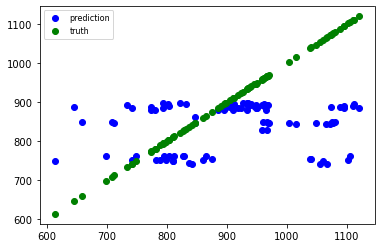

In [73]:

from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring

# use automl metrics module
scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all['predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

#Explore the results, another way

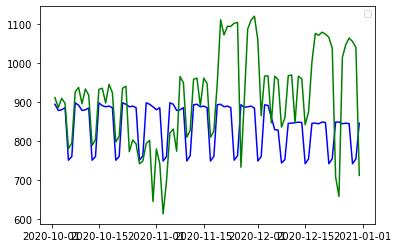

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 0 to 90
Data columns (total 26 columns):
Date                       91 non-null datetime64[ns]
_automl_dummy_grain_col    91 non-null object
predicted                  91 non-null float64
Departure_Airport          91 non-null object
Departure_state_x          91 non-null object
DOW_x                      91 non-null object
day_x                      91 non-null int64
month_x                    91 non-null object
mint                       91 non-null float64
maxt                       91 non-null float64
temp                       91 non-null float64
dew                        91 non-null float64
humidity                   91 non-null float64
wspd                       91 non-null float64
precip                     91 non-null float64
precipcover                91 non-null float64
snowdepth                  91 non-null float64
visibility                 91 non-null float64
cloudcover                 91 non-null float64
seal

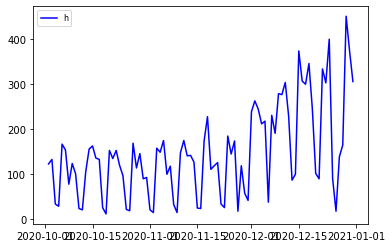

In [77]:
#plot the actual vs predicted as a time series plot
%matplotlib inline
test_pred = plt.plot(df_all['Date'], df_all['predicted'], color='b')
test_test = plt.plot(df_all['Date'], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='best', fontsize=8)
plt.show()

df_all.info()

covid= plt.plot(df_all['Date'], df_all['hospitalizedIncrease'], color='b')
plt.legend((covid), ('hospitalizedIncrease'), loc='best', fontsize=8)
plt.show()

In [78]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [79]:
from azureml.interpret import ExplanationClient
from azureml.core.run import Run
from interpret.ext.blackbox import TabularExplainer
from interpret_community.widget import ExplanationDashboard

run = Run.get_context()
client = ExplanationClient.from_run(remote_run)

explainer = TabularExplainer(fitted_model, 
                             train)

ValueError: Could not find valid explainer to explain model

In [ ]:
sum_actuals = sum_errors = 0

for actual_val, predict_val in zip(y_actual, y_predict):
    abs_error = actual_val - predict_val
    if abs_error < 0:
        abs_error = abs_error * -1

    sum_errors = sum_errors + abs_error
    sum_actuals = sum_actuals + actual_val

mean_abs_percent_error = sum_errors / sum_actuals
print("Model MAPE:")
print(mean_abs_percent_error)
print()
print("Model Accuracy:")
print(1 - mean_abs_percent_error)